In [1]:
import numpy as np
from scipy.linalg import circulant
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import comb

In [2]:
L = 1
T = 1
alpha = 1 / 512
beta = 33 / 32

n_X = 500
n_T = 500

target_T_sols = np.arange(0, 1.2, 0.2)
def execute_CN(n_X, n_T, target_T_sols):
    h = L / n_X
    k = T / n_T

    A0 = np.zeros(n_X)
    A0[1] = 1
    A0[-1] = -1

    B0 = np.zeros(n_X)
    B0[0] = -2
    B0[1] = 1
    B0[-1] = 1

    A = circulant(A0)
    B = circulant(B0)

    def g_init(x):
        return np.pow(np.sin(np.pi * x), 100)

    x_space = np.linspace(0, L, n_X+1)
    x_space = x_space[:-1] 

    u_curr = g_init(x_space).reshape(-1, 1)
    I = np.identity(n_X)
    c_A = beta * k / (4 * h)
    c_B = alpha * k / (2 * h**2)
    L_op = (I + c_A * A - c_B * B)
    R_op = (I - c_A * A + c_B * B)
    
    target_T_indices = [int(np.floor(t / k)) for t in target_T_sols]
    x_solutions = []
    x0_traj = [u_curr[0]]

    for t_i in tqdm(range(n_T)):
        if t_i in target_T_indices:
            x_solutions.append(np.vstack((u_curr, u_curr[0].reshape(1, 1))))
        u_half = R_op @ u_curr
        u_curr = np.linalg.solve(L_op, u_half)
        x0_traj.append(u_curr[0])
    if (t_i+1) in target_T_indices: # type: ignore
        x_solutions.append(np.vstack((u_curr, u_curr[0].reshape(1, 1)))) # Last time step
    return x_solutions, x0_traj

x_solutions, x0_traj = execute_CN(n_X, n_T, target_T_sols)

100%|██████████| 500/500 [00:05<00:00, 98.34it/s] 


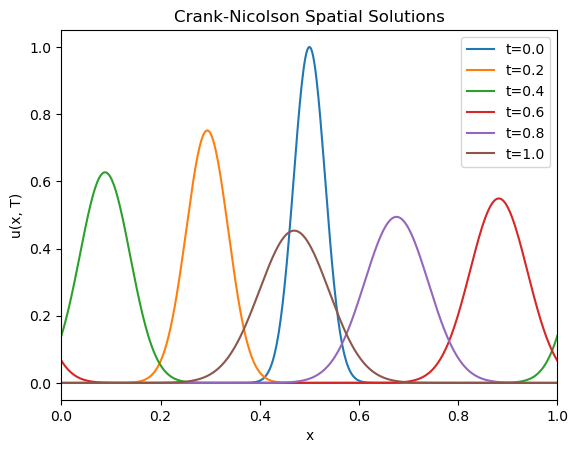

In [3]:
x_space = np.linspace(0, L, n_X + 1)
for t, sol in zip(target_T_sols, x_solutions):
    plt.plot(x_space, sol, label=f"t={round(t, 1)}")
plt.xlabel("x")
plt.ylabel("u(x, T)")
plt.legend()
plt.title("Crank-Nicolson Spatial Solutions")
plt.xlim((0.0,1.0))
plt.show()

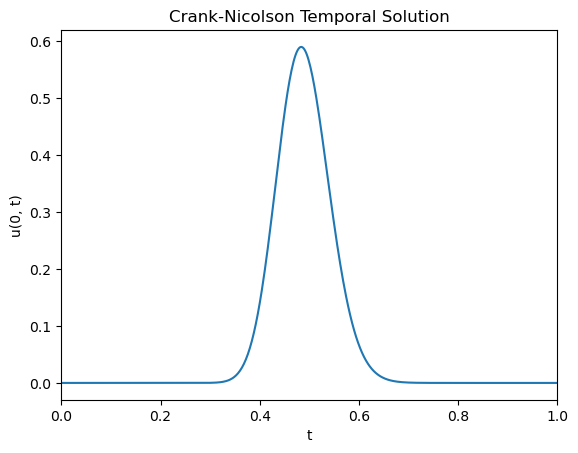

In [4]:
t_space = np.linspace(0, T, n_T + 1)
plt.plot(t_space, x0_traj)
plt.xlabel("t")
plt.ylabel("u(0, t)")
plt.title("Crank-Nicolson Temporal Solution")
plt.xlim(0.0, 1.0)
plt.show()

In [5]:
M = 128
x_samples = np.linspace(0, 1, M, endpoint=False)
g_samples = np.sin(np.pi * x_samples) ** 100
g_fourier = np.fft.fft(g_samples)
ck = np.real(np.roll(g_fourier, M // 2)) / M
buffer = M // 2 - 50
ck = ck[buffer:-buffer+1]
baseline_ck = np.array([comb(100, k + 50) * (2**(-100)) for k in range(-50, 51)]) * (-1) ** np.arange(0,101,1)

In [6]:
err = np.linalg.norm(ck - baseline_ck, 2)
print("Fourier Coefficient Error:", err)

Fourier Coefficient Error: 4.2854342817982286e-16


In [7]:
def calc_u(x, t):
    res = 0
    for i, c in enumerate(ck):
        k = i - 50
        t_coeff = -(4 * alpha * (np.pi**2) * (k**2) + 2 * beta * np.pi * 1j * k)
        x_coeff = 2 * np.pi * 1j * k
        expt = np.exp(t_coeff * t)
        expx = np.exp(x_coeff * x)
        term = c * expt * expx
        res += term
    return np.real(res)

In [8]:
exact_sol = calc_u(1/2, 1)
print("Exact:", exact_sol)
print("C-N", x_solutions[-1][n_X // 2][0])

Exact: 0.41023088876098807
C-N 0.4118688196747007


In [9]:
n_X_lst = [100, 250, 500, 750, 1000]
solutions = []
for n in n_X_lst:
    x_solutions, x0_traj = execute_CN(n, n, [1.0]) # k = h so n_T = n_X since L = T = 1
    solutions.append(x_solutions[0])

100%|██████████| 1000/1000 [00:32<00:00, 31.22it/s]


In [10]:
errors = [np.abs(s[n // 2][0] - exact_sol) for s, n in zip(solutions, n_X_lst)]
h_vals = [1 / n for n in n_X_lst]
slope  = np.log(errors[-2] / errors[-1]) / np.log(h_vals[-2] / h_vals[-1])
print(slope)

1.9961607864136466


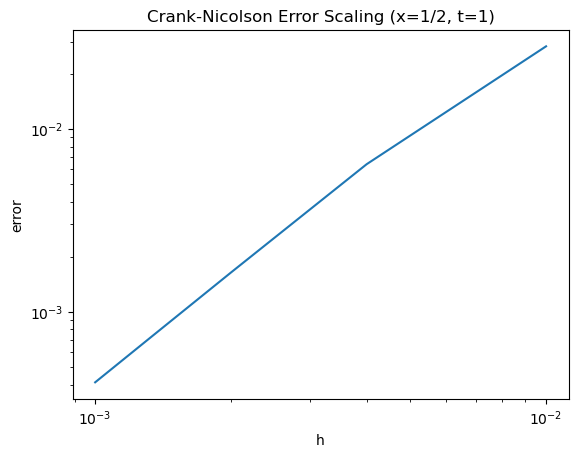

In [14]:
plt.plot(h_vals, errors)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("h")
plt.ylabel("error")
plt.title("Crank-Nicolson Error Scaling (x=1/2, t=1)")
plt.xticks([0.01,0.001])
plt.show()